In [41]:

# Importing required libraries
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pandas import DataFrame
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
store = pd.read_csv('D:/INFO442/data/preprocessed_store.csv')
train = pd.read_csv('D:/INFO442/data/preprocessed_train.csv', index_col='Date', parse_dates=True)
test = pd.read_csv('D:/INFO442/data/preprocessed_test.csv')


In [3]:
#pip install statsmodels
#pip install pmdarima

# EDA

In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [5]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [6]:
y = train['Sales'].resample('M').sum()

# Correlation

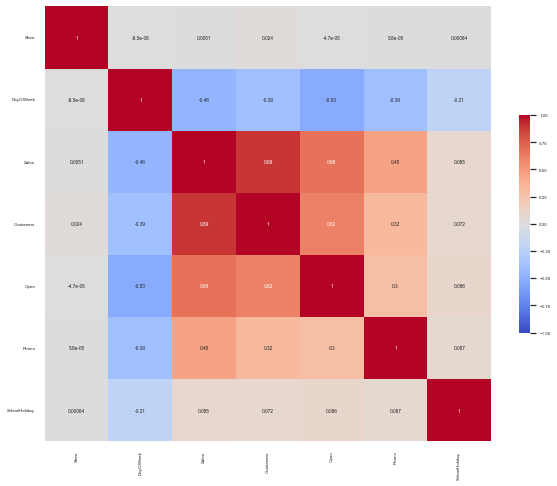

In [7]:
train_corr = train.corr()
# Setting the canvas size and font size
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.4)

# Generate heat maps, adjust label rotation and color scale size
ax = sns.heatmap(
    train_corr,
    annot=True,
    vmin=-1.0,
    vmax=1.0,
    center=0,
    cmap='coolwarm',
    cbar_kws={"shrink": 0.5}
)

# Rotating label
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

# Time Series Analysis

In [8]:
pd.plotting.register_matplotlib_converters()

In [9]:
# Data Preparation: input should be float type 

# our Sales data is int type so lets make it float
train['Sales'] = train['Sales'] * 1.00

train['Sales'].head()

Date
2015-07-31     5263.0
2015-07-31     6064.0
2015-07-31     8314.0
2015-07-31    13995.0
2015-07-31     4822.0
Name: Sales, dtype: float64

In [10]:
train.Store.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

In [11]:
import random

random_numbers = random.sample(range(1, 1116), 4)

In [12]:
random_numbers[1]

655

<AxesSubplot:xlabel='Date'>

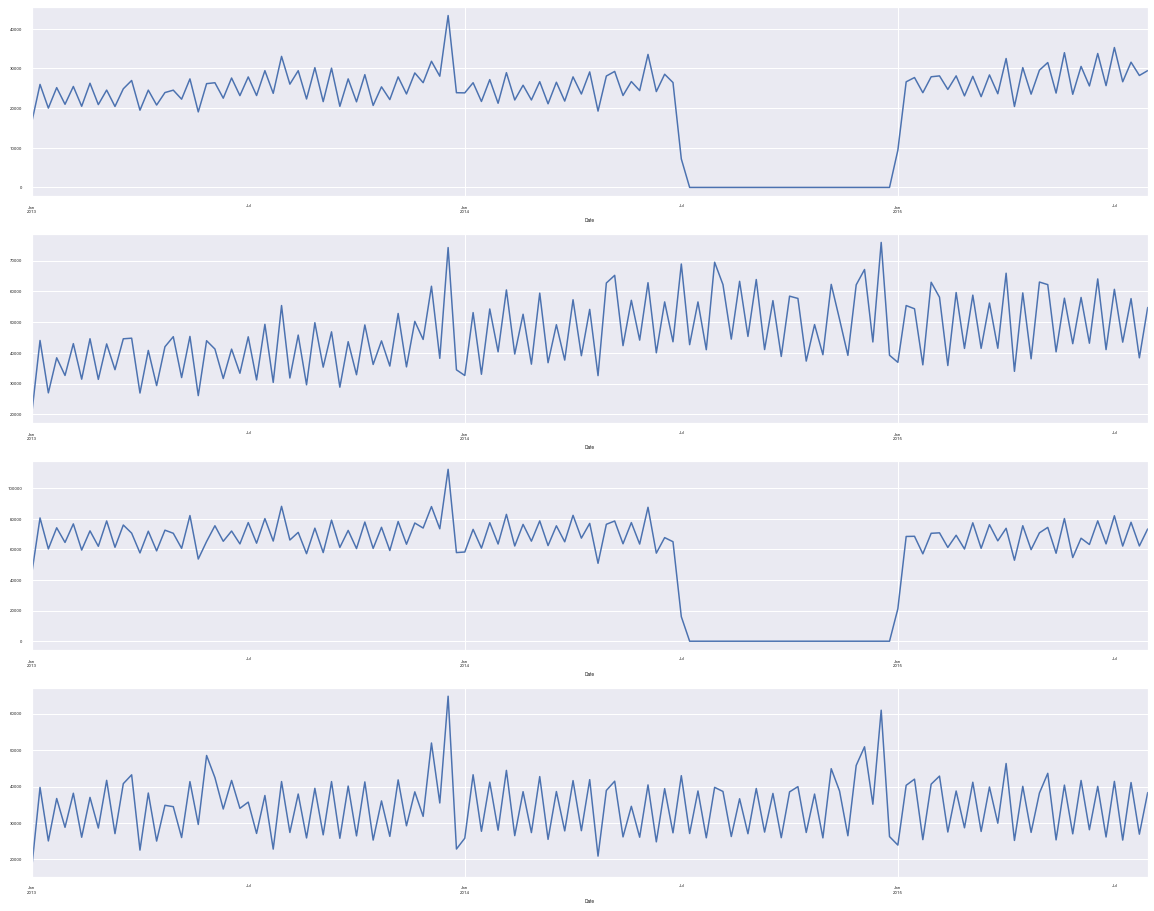

In [13]:
# Assigning one store from each category
sales_a = train[train.Store == random_numbers[0]]['Sales']
sales_b = train[train.Store == random_numbers[1]]['Sales'].sort_index(ascending = True) 
sales_c = train[train.Store == random_numbers[2]]['Sales']
sales_d = train[train.Store == random_numbers[3]]['Sales']

frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20, 16))

# Visualize Trend 
sales_a.resample('w').sum().plot(ax = ax1)
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)


# will be used to resample the speed column of our DataFrame
#The 'W' indicates we want to resample by week. At the bottom of this post is a summary of different time frames.
# You could use for Day = d, MOnth = m, Year = y

from the above analysis, we can draw conclusions:

Many stores have the highest sale at the end of the year, which is likely corresponded with holiday shopping season.

In addition to the observed patterns, the clear yearly trend in store sales suggests that the seasonality parameter in time series analysis should be set to a year. 

# Stationarity of Time Seriese

Stationarity is a fundamental in time series analysis, by making a series stationary, we can apply various statistical models and forecasting techniques more effectively, leading to more reliable and accurate predictions. Here we are using rolling mean and Augmented Dickey-Fuller (ADF) test to determine whether the data is stationary.

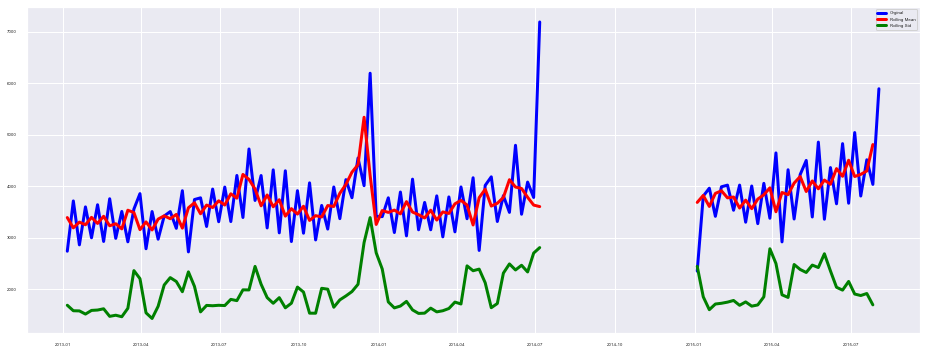

ADF Statestics: -3.467682
P-value: 0.008857
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [14]:
sample_store = sales_a
roll_mean = sample_store.rolling(window=12).mean()
roll_std = sample_store.rolling(window=12).std()
    
    
plt.subplots(figsize = (16, 6))
orginal = plt.plot(sample_store.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')    
roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    
plt.legend(loc='best')
plt.show()
    
#Augmented Dickey-Fuller (ADF) test result:
result= adfuller(sample_store, autolag='AIC')
    
    
print('ADF Statestics: %f' %result[0])
print('P-value: %f' %result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

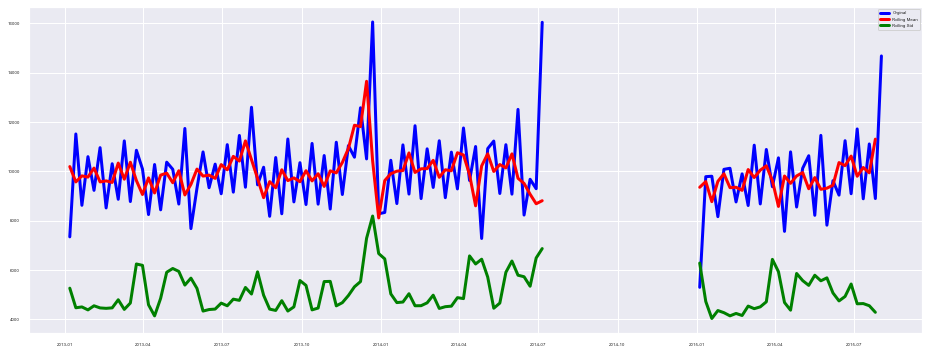

ADF Statestics: -5.034905
P-value: 0.000019
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [15]:
sample_store = sales_c
roll_mean = sample_store.rolling(window=12).mean()
roll_std = sample_store.rolling(window=12).std()
    
    
plt.subplots(figsize = (16, 6))
orginal = plt.plot(sample_store.resample('w').mean(), color='blue',linewidth= 3, label='Orginal')    
roll_mean = plt.plot(roll_mean.resample('w').mean(), color='red',linewidth= 3, label='Rolling Mean')
roll_mean = plt.plot(roll_std.resample('w').mean(), color='green',linewidth= 3, label='Rolling Std')
    
plt.legend(loc='best')
plt.show()


#Augmented Dickey-Fuller (ADF) test result:
result= adfuller(sample_store, autolag='AIC')
    
    
print('ADF Statestics: %f' %result[0])
print('P-value: %f' %result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales_a, model='additive', period=365)


estimated_trend = decomposition.trend
estimated_seasonal = decomposition.seasonal
estimated_residual = decomposition.resid

plt.figure(figsize=(5, 20))

<Figure size 360x1440 with 0 Axes>

<Figure size 360x1440 with 0 Axes>

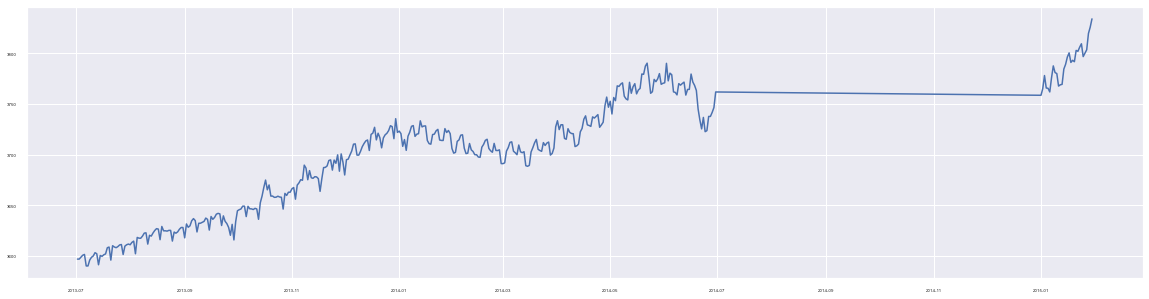

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(estimated_trend)
plt.show()

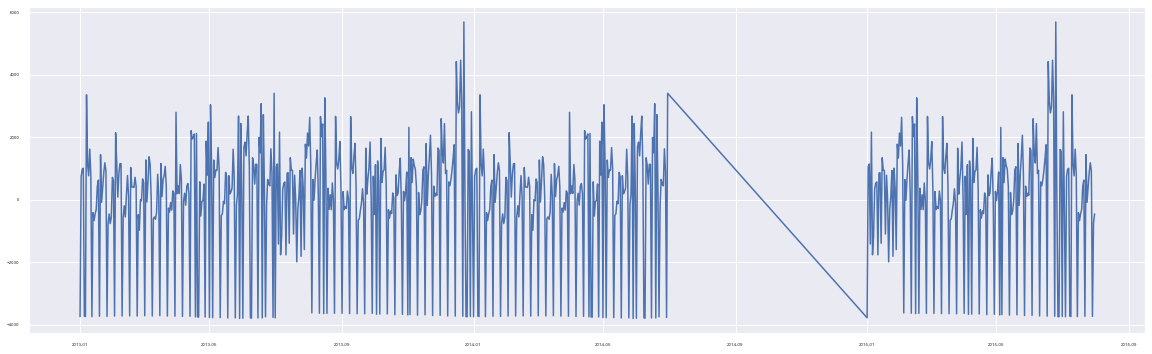

In [18]:
plt.figure(figsize=(20,6))
plt.plot(estimated_seasonal)
plt.show()

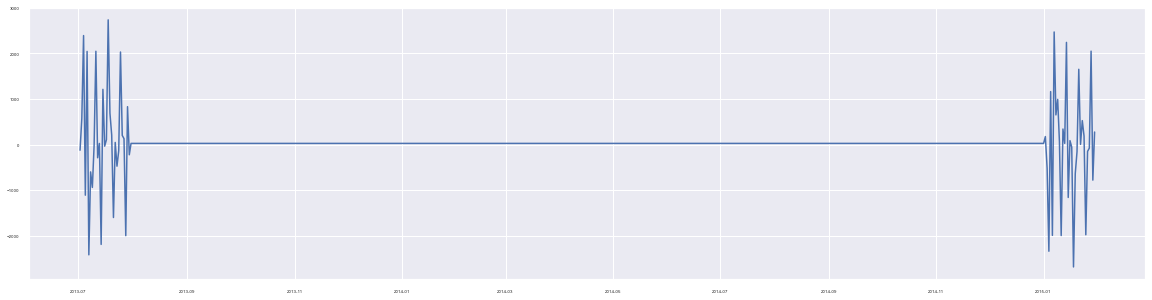

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(estimated_residual)
plt.show()

**Normalization**

# modeling

In [20]:
train_arima = train[['Sales']].resample('w').mean()

In [21]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [22]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_arima,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807690517
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207662
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.822052279851
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.705791267357
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857757
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107370084
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.3366943416113
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868305023007
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.0171891135683
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.6353259669916
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.042617136146
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.908596277383
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.441508975179
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842510296
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.58045319301
A

we can see that, the above grid search result our optimal paramiter (ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1807.348940844046)

In [23]:
# Fitting the data to SARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(train_arima,
                                        order=(1, 1, 1),
                                        seasonal_order=(1,1,1,12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
results_sarima= model_sarima.fit()
print(results_sarima.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -898.674
Date:                            Sun, 25 Aug 2024   AIC                           1807.349
Time:                                    15:19:13   BIC                           1820.760
Sample:                                01-06-2013   HQIC                          1812.786
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         


In [24]:
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5543      0.098     -5.652      0.000      -0.747      -0.362
ma.L1         -1.1418      0.055    -20.766      0.000      -1.250      -1.034
ar.S.L12      -0.1554      0.110     -1.417      0.156      -0.370       0.060
ma.S.L12      -1.0093      0.700     -1.441      0.150      -2.382       0.364
sigma2      6.236e+05   4.65e+05      1.342      0.180   -2.87e+05    1.53e+06


In [25]:
print(results_sarima.summary().tables[2])

Ljung-Box (L1) (Q):                   0.83   Jarque-Bera (JB):                32.84
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.76
Prob(H) (two-sided):                  0.75   Kurtosis:                         5.24


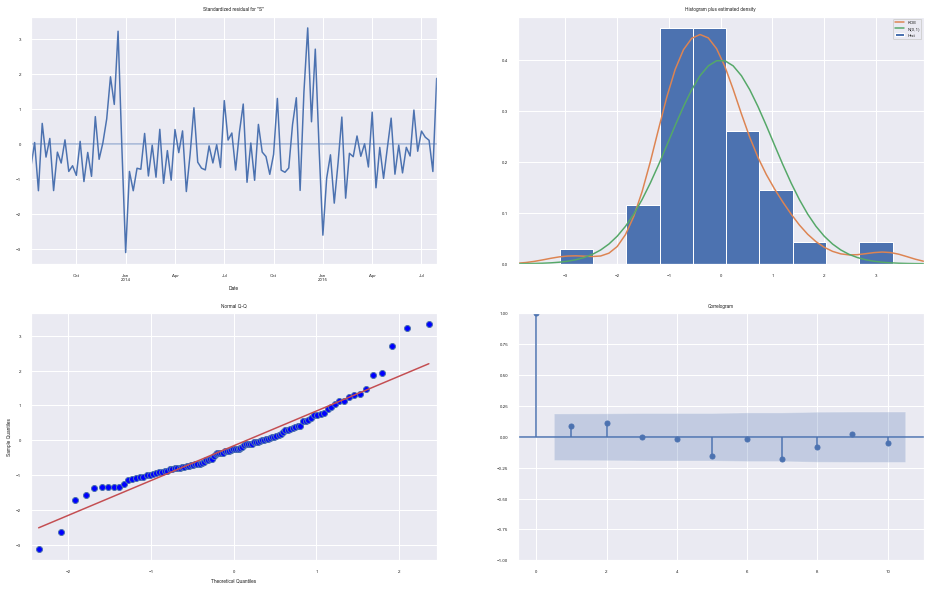

In [26]:
results_sarima.plot_diagnostics(figsize=(16, 10))
plt.show()

**Standardized Residuals:**

displays the residuals

**Histogram plus KDE Plot:**

residuals along with a Kernel Density Estimate (KDE) of the residual distribution. the residuals are normally distributed.

**Normal Q-Q Plot:**

Deviations from this line indicate that the residuals do not follow a normal distribution, which can affect the model's accuracy and reliability.

**Correlogram (ACF Plot) of Residuals:**

the significant autocorrelation at any lag suggests some information is still present in the residuals.

holidays can significantly impact the pattern of the series. These impacts are often not captured by standard SARIMA models unless explicitly accounted for.we can create binary indicators (dummy variables) for holidays and include them as exogenous variables in the SARIMA model. This way, the model explicitly accounts for the holiday effects.

In [27]:
train['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [28]:
train['StateHoliday']= train['StateHoliday'].replace('0', 0)
train['StateHoliday']= train['StateHoliday'].replace('a', 1)
train['StateHoliday']= train['StateHoliday'].replace('b', 2)
train['StateHoliday']= train['StateHoliday'].replace('c', 3)

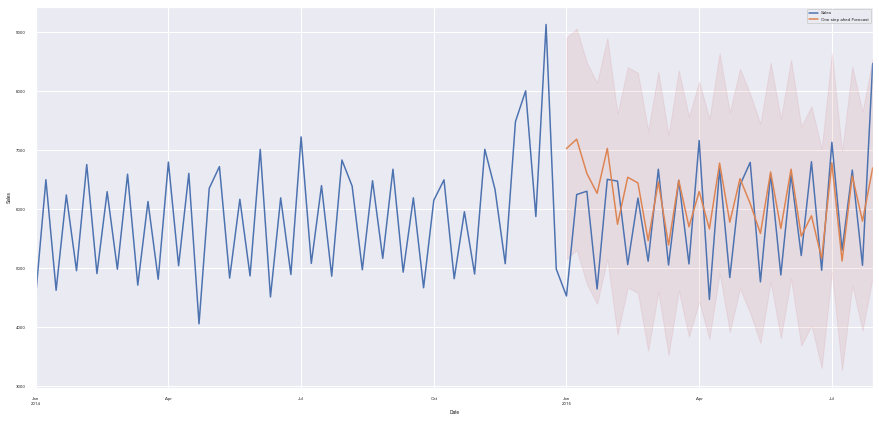

Root Mean Squared Error =  867.9550721313967


In [29]:
# Model prediction 

pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

# Get confidence interval of forecast 
pred_ci = pred.conf_int()

ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)

ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1],
               color='r', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima['2015-01-04':]

rms_arima= sqrt(mean_squared_error(train_arima_truth,train_arima_forecasted))
print('Root Mean Squared Error = ',rms_arima)

In [35]:
train_holiday = train[['StateHoliday']].resample('w').mean()

In [36]:


mod = sm.tsa.statespace.SARIMAX(train_arima,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                exog=train_holiday,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1660.9551524846956


In [37]:

print(results.summary().tables[0])
print(results.summary().tables[1])
print(results.summary().tables[2])

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  135
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -823.478
Date:                            Sun, 25 Aug 2024   AIC                           1660.955
Time:                                    15:27:42   BIC                           1679.730
Sample:                                01-06-2013   HQIC                          1668.568
                                     - 08-02-2015                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
StateHoliday -1368.1294    286.117     -4.782      0.000   -1928.908    -807.351
Promo         2441.1638    10

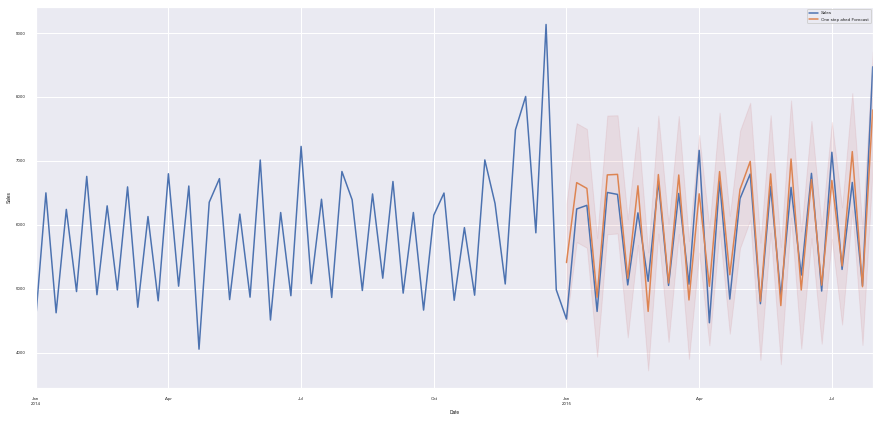

Mean Squared Error =  130272.73523815954
Root Mean Squared Error =  360.9331451088408
Mean Absolute Error =  292.93480733348406


In [42]:
# Model prediction 

pred = results.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

# Get confidence interval of forecast 
pred_ci = pred.conf_int()

ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)

ax.fill_between(pred_ci.index, 
               pred_ci.iloc[:, 0],
               pred_ci.iloc[:,1],
               color='r', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

train_arima_forecasted = pred.predicted_mean
train_arima_truth = train_arima['2015-01-04':]

mse_arima=mean_squared_error(train_arima_truth,train_arima_forecasted)
rmse_arima= sqrt(mean_squared_error(train_arima_truth,train_arima_forecasted))
mae_arima =  mean_absolute_error(train_arima_truth,train_arima_forecasted)
print('Mean Squared Error = ',mse_arima)
print('Root Mean Squared Error = ',rmse_arima)
print('Mean Absolute Error = ',mae_arima)

After testing all combinations of external regressors (exog), it was found that incorporating both promotion and holidays as exogenous variables provided the best fit for the model. This combination of external factors improved the model’s accuracy and predictive performance, leading to more reliable forecasts.

In [34]:
# Save your predicted results for future validation. 
# You could find this results in output sections

train_arima_forecasted.to_csv('predicted_data.csv')
print('Predicted Data Saved in output')

Predicted Data Saved in output
